预训练网络是一个保存好的，之前在大型数据集上训练好的网络。

本例使用 VGG16 ，对于 ImageNet ，它是一种简单而又广泛使用的卷积神经网络架构。

使用预训练网络有两种方法：特征提取和微调模型。

## 特征提取

特征提取是使用之前网络学到的表示来从新样本中提取出有趣的特征。然后将这些特征输入一个新的分类器，从头开始训练。

对于图像分类的卷积神经网络包含两部分：首先是一系列池化层和卷积层，最后是一个密集连接分类器。

第一部分叫做模型的卷积基。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器。

本例，使用在 ImageNet 上训练的 VGG16 网络的卷积基从猫狗图像中提取有趣的特征，然后在这些特征上训练一个猫狗分类器。

### 将 VGG 卷积基实例化

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',#指定模型初始化的权重检查点
                  include_top=False,#指定模型最后是否包含全连接分类器，VGG自带1000个类别分类，本例只需要猫狗两类，所以无需包含
                  input_shape=(150, 150, 3)#输入张量的形状，如果不传入此参数，网络能处理任意形状的输入
                 )

Instructions for updating:
Colocations handled automatically by placer.


VGG16 卷积基的详细架构：

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

最后的特征图形状为 (4, 4, 512)。我们将在这个特征上添加一个密集连接分类器。有两种方法：

（1）在数据集上运行卷积基，将输出保存成硬盘中的 Numpy 数组，然后用这个数据作为输入，输入到独立的全连接分类器中。速度快，计算代价低。对于输入图像只需运行一次卷积基，但无法使用数据增强。

（2）在顶部添加 Dense 层来扩展已有模型（即 conv_base），并在输入数据上端到段地运行整个模型，可以使用数据增强，计算代价高。

### 不使用数据增强的快速特征提取

首先，运行 ImageDataGenerator 实例，将图像及其标签提取为 Numpy 数组。调用 conv_base 模型的 predict 方法来从这些图像中提取特征。

#### 使用预训练的卷积基提取特征

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/home/cqc/文档/git/DeepLearning_with_Keras/datasets/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i=0
    for inputs_batch, label_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = label_batch
        i+=1
        if i * batch_size >= sample_count:
            break   #读取完所有图像后终止生成器
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


/home/cqc/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


目前，提取的特征形状为 (samples, 4, 4, 512)。我们需要将其输入到密集连接分类器中，所以首先必须将其形状展平为 (samples, 8192)。

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

#### 定义并训练密集连接分类器

In [7]:
from keras import models
from keras import layers
from keras import optimizers

In [9]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 2ms/step - loss: 4.5526 - acc: 0.6440 - val_loss: 1.4692 - val_acc: 0.8390
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 1.9885 - acc: 0.8250 - val_loss: 1.0582 - val_acc: 0.8940
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 1.5102 - acc: 0.8690 - val_loss: 1.1534 - val_acc: 0.8960
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0805 - acc: 0.9015 - val_loss: 0.8306 - val_acc: 0.9050
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0145 - acc: 0.8950 - val_loss: 0.7546 - val_acc: 0.9180
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.9051 - acc: 0.9130 - val_loss: 0.7441 - val_acc: 0.9260
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6648 - acc: 0.9395 - v

#### 绘制结果

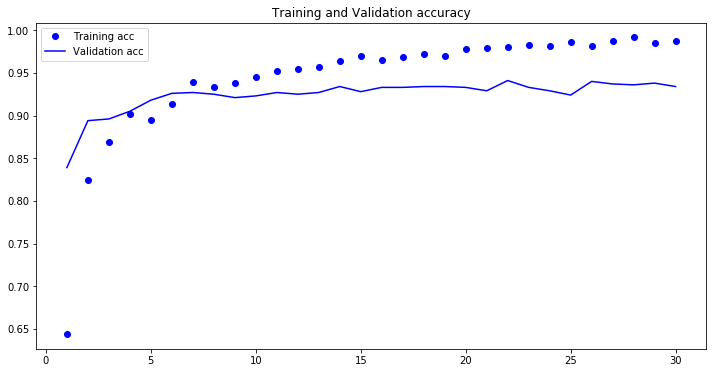

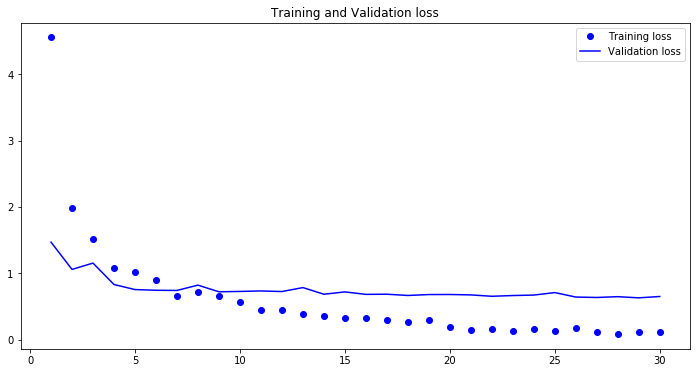

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

验证精度达到了约90%，虽然 Dropout 比率相当大，但还是存在过拟合。这是因为没有使用数据增强，而数据增强对防止小型图像数据集的过拟合非常重要。